# 🧠 `serket` mental model
1) **Single Sample Code**: Write code for a single data sample (un-batched) and use `jax`'s `vmap` to apply it to a batch of data. This approach is efficient and concise.

2) **Functional updates of stateful Object-Oriented Code**: write stateful object-oriented code. with functional updates.

3) **Transformation Transparent Code**: Write code that works under any `jax` transformation. This approach makes the code reusable, easier to understand, and less error-prone.

The following code showcases these principles

In [1]:
!pip install git+https://github.com/ASEM000/serket --quiet

## Model definition

In [1]:
import jax
import functools as ft
import serket as sk
import matplotlib.pyplot as plt


class Linear(sk.TreeClass):
    def __init__(self, in_features: int, out_features: int, key: jax.Array):
        self.weight = jax.random.normal(key, (in_features, out_features))
        self.bias = jax.numpy.zeros((out_features,))
        self.counter = 0.0

    def __call__(self, x: jax.Array):
        return x @ self.weight + self.bias


# to showcase the functional update of with stateful modules
# lets define a tree of modules with stateful updates in the call method


class Linears(sk.TreeClass):
    def __init__(self, *, key: jax.Array):
        k1, k2, k3 = jax.random.split(key, 3)
        self.l1 = Linear(1, 120, key=k1)
        self.l2 = Linear(120, 120, key=k2)
        self.l3 = Linear(120, 1, key=k3)

    def mutating_method(self, input: jax.Array) -> jax.Array:
        # stateful updates
        self.l1.counter += 1.0
        self.l2.counter += 1.0
        self.l3.counter += 1.0

        # forward pass for single sample
        output = self.l1(input)
        output = jax.numpy.tanh(output)
        output = self.l2(output)
        output = jax.numpy.tanh(output)
        output = self.l3(output)
        return output
    
    def non_mutating_method(self, input: jax.Array) -> jax.Array:
        # forward pass for single sample
        output = self.l1(input)
        output = jax.numpy.tanh(output)
        output = self.l2(output)
        output = jax.numpy.tanh(output)
        output = self.l3(output)
        return output

## Non-mutating methods

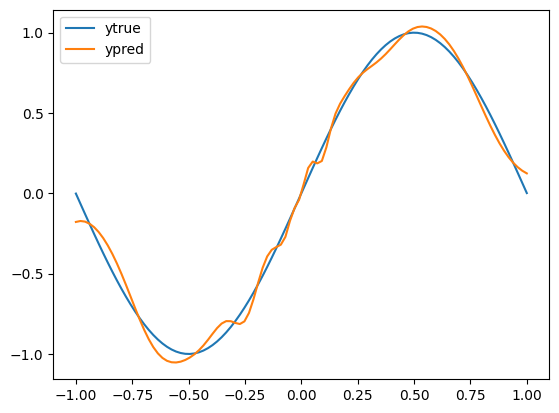

In [2]:
net = Linears(key=jax.random.PRNGKey(42))
x = jax.numpy.linspace(-1, 1, 100)[:, None]
y = jax.numpy.sin(x * 3.14)

@jax.grad
def loss_func(net: Linears, x: jax.Array, y: jax.Array):
    # apply net to
    # (1) batched input -> use jax.vmap on net
    ypred = jax.vmap(net.non_mutating_method)(x)
    return jax.numpy.mean((y - ypred) ** 2)


@jax.jit
def train_step(net: Linears, x: jax.Array, y: jax.Array):
    net_grad = (loss_func)(net, x, y)
    net = jax.tree_map(lambda x, y: x - 1e-3 * y, net, net_grad)
    return net


for i in range(1_000):
    net = train_step(net, x, y)

ypred = jax.vmap(net.non_mutating_method)(x)

plt.plot(x, y, label="ytrue")
plt.plot(x, ypred, label="ypred")
plt.legend()

## Mutating methods

To make the model work seamlessly with the rest of `jax` transformation, mutating method needs to be functionalized using `sk.value_and_tree`. `sk.value_and_tree` copies the input arguments and allow the method to mutate the copy. Then the method output is returned alongside with the mutated copy.

In [3]:
net = Linears(key=jax.random.PRNGKey(42))

# serket does not allow stateful updates directly and any stateful updates
# will result in an error
try:
    net.mutating_method(x[0])
except AttributeError as e:
    print(e)

Cannot set attribute value=1.0 to `key='counter'`  on an immutable instance of `Linear`.


In [4]:
# instead we can use the functional update method
output, new_net = sk.value_and_tree(lambda net, x: net.mutating_method(x))(net, x[0])
new_net.l1.counter, new_net.l2.counter, new_net.l3.counter

(1.0, 1.0, 1.0)

l1 counter = 1000.0
l2 counter = 1000.0
l3 counter = 1000.0


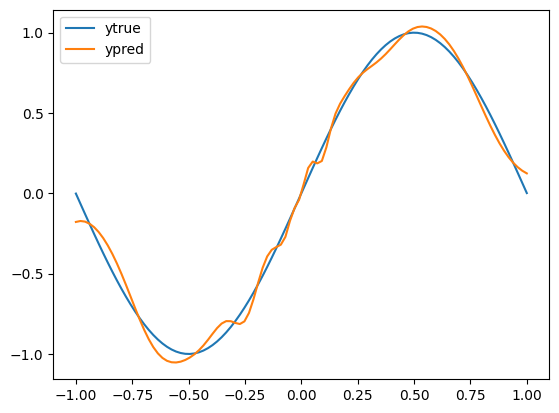

In [5]:
net = Linears(key=jax.random.PRNGKey(42))
x = jax.numpy.linspace(-1, 1, 100)[:, None]
y = jax.numpy.sin(x * 3.14)

# because the `mutating_method` method of Linears is mutating the state
# we have to apply a transformation `value_and_tree` to make it work
# and return the updated state
# the following function takes a net and an input and returns the output and the updated net
value_and_net = sk.value_and_tree(lambda net, input: net.mutating_method(input))


@ft.partial(jax.grad, has_aux=True)
def loss_func(net: Linears, x: jax.Array, y: jax.Array):
    # apply net to
    # (1) batched input -> use jax.vmap on net
    # (2) functional stateful updates -> use sk.value_and_tree on mutating methods
    # in_axes = (None, 0) -> net is not batched, x is batched
    # out_axes = (0, None) -> output is batched, net is not batched
    ypred, net = jax.vmap(value_and_net, in_axes=(None, 0), out_axes=(0, None))(net, x)
    # here net state is updated
    return jax.numpy.mean((y - ypred) ** 2), net


@jax.jit
def train_step(net: Linears, x: jax.Array, y: jax.Array):
    net_grad, net = (loss_func)(net, x, y)
    net = jax.tree_map(lambda x, y: x - 1e-3 * y, net, net_grad)
    return net


for i in range(1_000):
    net = train_step(net, x, y)

ypred, _ = jax.vmap(value_and_net, in_axes=(None, 0), out_axes=(0, None))(net, x)

plt.plot(x, y, label="ytrue")
plt.plot(x, ypred, label="ypred")
plt.legend()

print(f"l1 counter = {net.l1.counter}")
print(f"l2 counter = {net.l2.counter}")
print(f"l3 counter = {net.l3.counter}")